### This notebook is for reading in image data and using the AstrocalibRead package to perform necessary data analysis and calculations to obtain a distortion field. Some plots are plotted in the end to perform checks during certain steps in the calculation of the distoriton field.

In [2]:
import glob
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from astropy.io import fits
from PrototypingRead import AstrocalibRead
%reload_ext autoreload
%autoreload 2

In [81]:
#Function to grab image data
def get_image(at,background=None):
    """Obtain Image given the path"""
    #"background" is the background lighting when the lamp is turned off
    grid_null = []
    for each_file in glob.glob(at):
        grid_null.append(fits.open(each_file))
        grid_null[-1]=grid_null[-1][0].data
        if background is not None:
            grid_null[-1]=grid_null[-1]-background #sub-tracting the dark
    return grid_null

In [82]:
#Enter background location
bg_loc='./2023-05-02/0.1sbackground*'   

#Enter file locations:
shifty='./2023-05-02/1sgreenhome_d*'
shiftx='./2023-05-02/1sgreen_xright*'                                   
home='./2023-05-02/1sgreen_yup*'


bg = np.mean(get_image(bg_loc),axis=0)
data1 = pd.DataFrame({'home':get_image(home,bg),'shiftx':get_image(shiftx,bg),'shifty':get_image(shifty,bg)})

In [83]:
#Enter file locations:
shifty='./2023-05-02/0.1sgreen_home*'
shiftx='./2023-05-02/0.1sgreen_left*'                                   
home='./2023-05-02/0.1sgreen_down*'
data0 = pd.DataFrame({'home':get_image(home,bg),'shiftx':get_image(shiftx,bg),'shifty':get_image(shifty,bg)})

In [84]:
#locations of the 4 corners: top-left, top-right, bottom-left, bottom-right (0,0 at bottom-left)
home=np.array([[313, 3902], [3911, 3906], [314, 325], [3903, 319]])  
home1=np.array([[ 283, 3927],[3881, 3931],[ 284,  350],[3873,  344]])

#x-shift: 
dx=-35 
dx1=30        

#y-shift: 
dy=25  
dy1=-50

#37 x 37 grid
dimension = 37 

corners = pd.DataFrame({'data':[home1],'dimension':dimension,'dx':dx1,'dy':dy1})
corners0 = pd.DataFrame({'data':[home],'dimension':dimension,'dx':dx,'dy':dy})

In [85]:
No_Dist_Set = AstrocalibRead(data0,corners0,mode='C',peak='yes')
Dist1_Set = AstrocalibRead(data1,corners,mode='C',peak='yes')


In [427]:
# Values to evaluate distortion functions with. Can be any arangement of 
# coordinates within the science field.
nsamp = 31
xx,yy = np.meshgrid(np.linspace(-15,15,nsamp),np.linspace(-15,15,nsamp))
xx = xx.flatten()
yy = yy.flatten()
rrr = (xx**2+yy**2)**0.5

# Only calculate the field inside the field of radius rad
rad=10
xx = xx[rrr<=rad]
yy = yy[rrr<=rad]



# Calculate recovered distortions at xx/yy coordinates
#recovered_dist_xx,recovered_dist_yy = No_Dist_Set.recovered_dist(xx,yy,6,mode='G') #Gaussian
recovered_dist0_xxC,recovered_dist0_yyC = No_Dist_Set.recovered_dist(xx,yy,n_poly=6,r=rad) #Cendroid
recovered_dist_xxC,recovered_dist_yyC = Dist1_Set.recovered_dist(xx,yy,n_poly=6,r=rad) #Cendroid

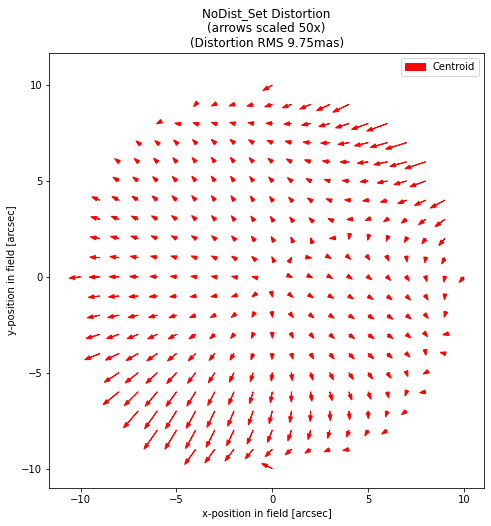

In [428]:
# plot recovered

plt.figure(figsize=[8,8])
arrow_sf = 50
Distortion_scale = np.sqrt(np.mean(recovered_dist0_xxC**2+recovered_dist0_yyC**2))*1000 #RMS of the arrows
for i in range(xx.shape[0]):
    #plt.arrow(xx[i],yy[i],arrow_sf*recovered_dist_xx[i],arrow_sf*recovered_dist_yy[i],
     #       color="b",head_width=0.1,width=0.01,length_includes_head=True)
    plt.arrow(xx[i],yy[i],arrow_sf*recovered_dist0_xxC[i],arrow_sf*recovered_dist0_yyC[i],
            color="r",head_width=0.2,width=0.01,length_includes_head=True)
    plt.axis("square")
#plt.legend(["Gaussian","Centroid"])
plt.legend(["Centroid"])
plt.title(f"NoDist_Set Distortion\n(arrows scaled {arrow_sf:0.0f}x)\n(Distortion RMS {Distortion_scale:0.2f}mas)")
plt.xlabel("x-position in field [arcsec]")
plt.ylabel("y-position in field [arcsec]")
#plt.savefig('../../../Dist1_Set.pdf')
plt.show()

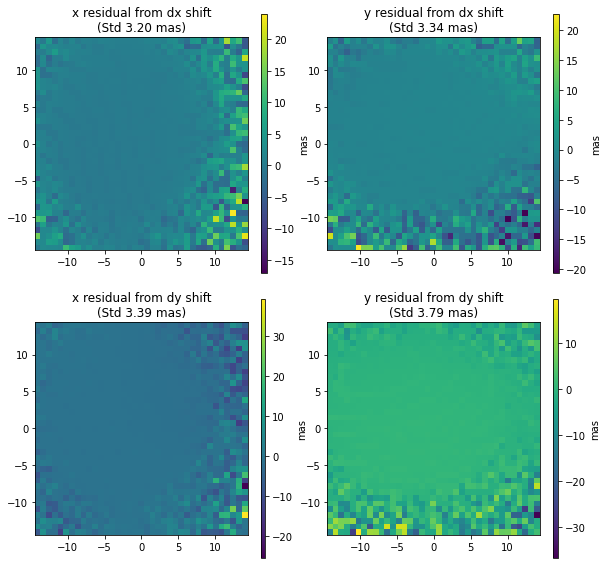

In [429]:
No_Dist_Set.plot_dxdy()

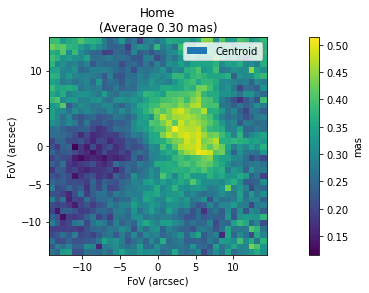

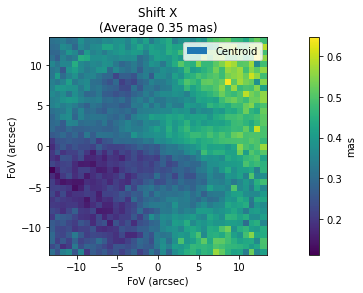

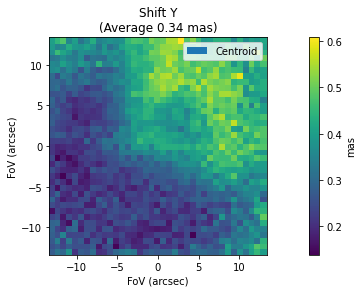

In [430]:
No_Dist_Set.plot_std()

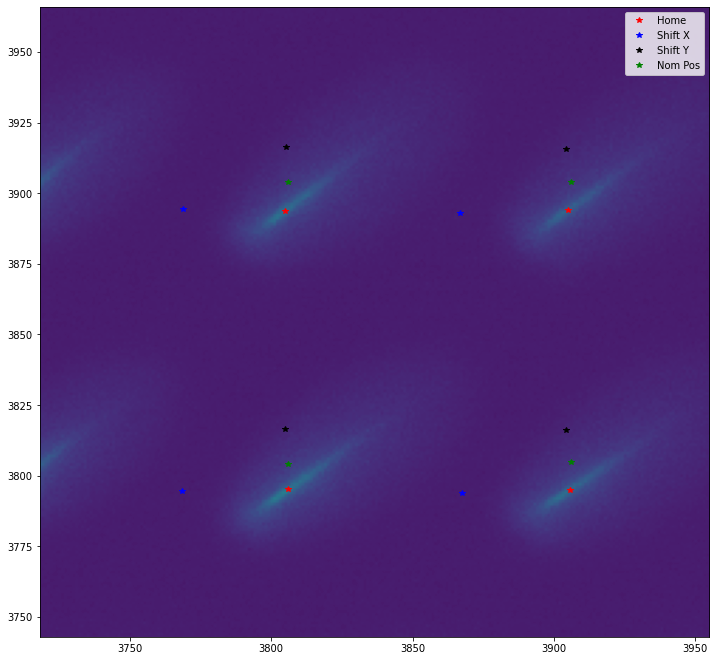

In [ ]:
No_Dist_Set.plot_pos(35,37,35,37,image='home')

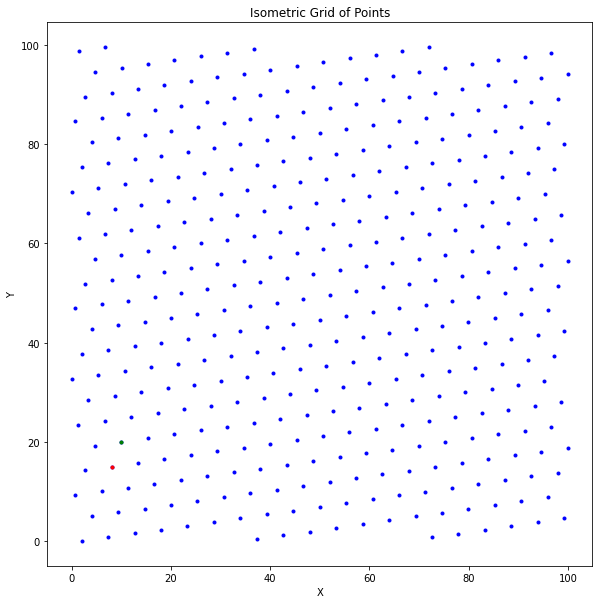

In [3]:
def make_hex_grid(p1,p2,lim):
    """
    First create a hexagonal grid and then rotate it to match the input points.
    p1:     [..,..]
    p2:     [..,..]        The adjacent shortest point to p1
    lim:    [0,4096]
    """

    point_spacing = ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5
    mid_point = [(p1[0]+p2[0])/2 , (p1[1]+p2[1])/2]


    y_small = mid_point[1]-point_spacing/2     #first point of y in smaller direction
    ny = math.floor(np.sqrt(2)*np.max(lim)/point_spacing)     #amount of points needed to reach the limit.
    y_min_point = y_small-point_spacing*(ny)    #smallest y-valued point
    num_points = ny*2+2                # Number of points in y


    x_spacing = np.sqrt(point_spacing**2-(point_spacing/2)**2)

    x_mid = mid_point[0]
    nx = math.floor(np.sqrt(2)*np.max(lim)/x_spacing) 
    x_min_point = x_mid-x_spacing*(nx+(nx % 2)) #Add an extra row if the input points exist in a 'middle' row


    # Create arrays to store x and y coordinates of points
    x_coords = []
    y_coords = []


    for row in range(num_points):
        for col in range(math.ceil(num_points*point_spacing/x_spacing)): #so that the output looks like a square grid
            x = x_min_point + col * x_spacing
            y = y_min_point + row * point_spacing + (col % 2) * point_spacing / 2
            x_coords.append(x)
            y_coords.append(y)


    x_reshaped = np.array(x_coords).reshape([num_points,math.ceil(num_points*point_spacing/x_spacing)]) - mid_point[0]
    y_reshaped = np.array(y_coords).reshape([num_points,math.ceil(num_points*point_spacing/x_spacing)]) - mid_point[1]

    sign=1
    if p1[1]-p2[1]<0:
        sign= -1
    RotRad = np.arctan((p1[0]-p2[0])/2/np.abs((p1[1]-p2[1])/2))*sign


    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                        [-np.sin(RotRad), np.cos(RotRad)]])
    #return x,y
    grid = np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x_reshaped, y_reshaped]))
    rot_x = (grid[0]+mid_point[0]).flatten() #returns to original position
    rot_y = (grid[1]+mid_point[1]).flatten()

    mask = (0 < rot_x) & (rot_x < lim[0]) & (0 < rot_y) & (rot_y < lim[1])
    
    return rot_x[mask], rot_y[mask]
    



p1=[8,15]
p2=[10,20]
lim=[100,100] #specify the desired x and y dimension

rot_x,rot_y = make_hex_grid(p1,p2,lim)

# Plot the points
plt.figure(figsize=[10,10])
plt.plot(rot_x, rot_y, '.b')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(p1[0],p1[1],'.r')
plt.plot(p2[0],p2[1],'.g')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Isometric Grid of Points')
plt.show()



In [417]:
rot_x.all()[0<rot_x<100]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()